In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.utils import shuffle, resample
from sklearn.metrics import classification_report

data = pd.read_csv("/datasets/Churn.csv")

In [114]:
print(data.shape)
print()
print("Duplicated", data.duplicated().sum())

(10000, 14)

Duplicated 0


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [116]:
### Rellenar los valores NaN a ceros

data['Tenure'].fillna(0, inplace=True)

In [117]:
### Transformacion de datos categoricos en datos numericos

data_ohe = pd.get_dummies(data, drop_first=True)

In [118]:
### Estandarizacion de datos numericos

target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

/tmp/ipykernel_126/3616369927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_126/3616369927.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [119]:
### Arbol de decision

decision_tree_model = DecisionTreeClassifier(random_state=12345)
decision_tree_model.fit(features_train, target_train)

decision_tree_predicted_valid = decision_tree_model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, decision_tree_predicted_valid)

print("Exactitud del modelo: ", accuracy_valid)

Exactitud del modelo:  0.818


In [120]:
### Frecuencia de clases

class_frequency = target.value_counts(normalize=True)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<AxesSubplot:title={'center':'Desequilibrio de clases del valor objetivo'}, xlabel='El cliente se ha ido?'>

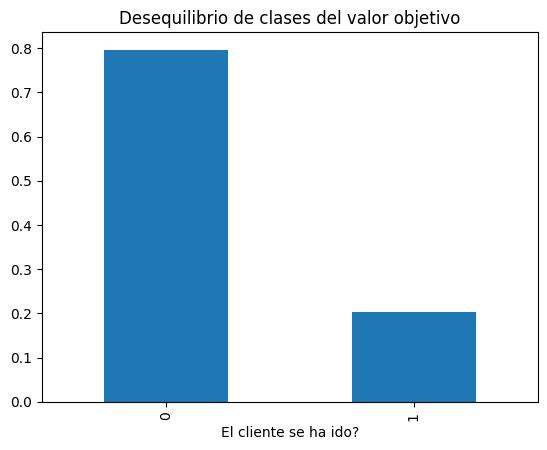

In [121]:
class_frequency.plot(kind='bar', xlabel='El cliente se ha ido?', title='Desequilibrio de clases del valor objetivo')

In [122]:
### Frecuencia de clases del modelo
decision_tree_predicted_valid_series = pd.Series(decision_tree_model.predict(features_valid))

predicted_class_frequency = decision_tree_predicted_valid_series.value_counts(normalize=True)
predicted_class_frequency

0    0.82
1    0.18
dtype: float64

<AxesSubplot:title={'center':'Desequilibrio de clases del modelo'}, xlabel='El cliente se ha ido?'>

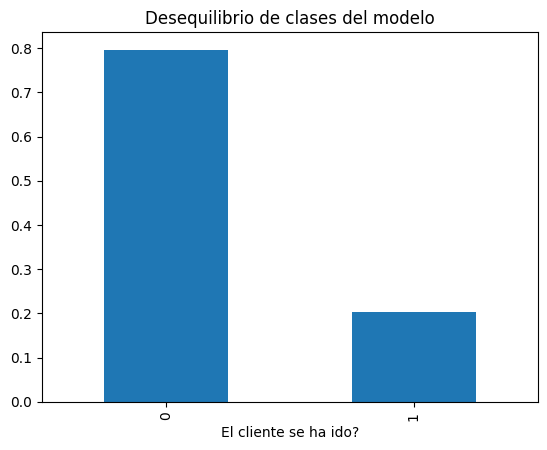

In [123]:
class_frequency.plot(kind='bar', xlabel='El cliente se ha ido?', title='Desequilibrio de clases del modelo')

In [124]:
### Exacitud del modelo con un modelo constante

target_pred_constant = pd.Series(0, index=target.index)

accuracy = accuracy_score(target, target_pred_constant)
print("Exactitud del modelo constante: ", accuracy_valid)

Exactitud del modelo constante:  0.818


In [125]:
### La exactitud del árbol de decisión es casi la misma que la del modelo constante.
### Hay un fuerte desequilibrio de clases

In [126]:
### Metricas
### proporción de todos los positivos reales que se clasificaron correctamente como positivos
model_recall = recall_score(target_valid, decision_tree_predicted_valid_series)
print("Recall:", model_recall)
print()

### proporción de todas las clasificaciones positivas del modelo que realmente son positivas.
model_precision = precision_score(target_valid, decision_tree_predicted_valid_series)
print("Precision", model_precision)
print()

### F1
model_f1 = f1_score(target_valid, decision_tree_predicted_valid_series)
print("F1:", model_f1)

Recall: 0.4953271028037383

Precision 0.5888888888888889

F1: 0.5380710659898477


In [127]:
### Ajuste de peso con Regresion Logistica

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced', max_iter=500)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))
print()
print(classification_report(target_valid, predicted_valid))

F1: 0.46243617797228304

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1965
           1       0.38      0.59      0.46       535

    accuracy                           0.71      2500
   macro avg       0.62      0.66      0.63      2500
weighted avg       0.76      0.71      0.73      2500



In [128]:
### Sobremuestreo

def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [129]:
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 15
)

In [130]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)

predicted_valid = pd.Series(model.predict(features_valid))

model_f1 = f1_score(target_valid, predicted_valid)

print('F1 for upsampled data:', model_f1)
print()
print(classification_report(target_valid, predicted_valid))

F1 for upsampled data: 0.3525535420098847

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1965
           1       0.21      1.00      0.35       535

    accuracy                           0.21      2500
   macro avg       0.11      0.50      0.18      2500
weighted avg       0.05      0.21      0.08      2500



/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
### Submuestreo

def downsample(features, target, fraction):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = features_zeros.sample(frac=fraction, random_state=12345)
    features_downsampled = pd.concat([features_downsampled, features_ones])
    
    target_downsampled = target_zeros.sample(frac=fraction, random_state=12345)
    target_downsampled = pd.concat([target_downsampled, target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [132]:
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.2
)

In [133]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)

predicted_valid = pd.Series(model.predict(features_valid))

downsampled_model_f1 = f1_score(target_valid, predicted_valid)

print('F1 for downsampled data:', downsampled_model_f1)

F1 for downsampled data: 0.3525535420098847


In [134]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = (probabilities_one_valid >= threshold).astype(int) # < escribe el código aquí >
    precision = precision_score(target_valid, predicted_valid) # < escribe el código aquí >
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid) # < escribe el código aquí >

    print(
            'Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}'.format(
                threshold, precision, recall, f1
            )
        )


Threshold = 0.00 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.02 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.04 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.06 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.08 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.10 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.12 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.14 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.16 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.18 | Precision = 0.214, Recall = 1.000, F1 = 0.353
Threshold = 0.20 | Precision = 0.224, Recall = 0.607, F1 = 0.327
Threshold = 0.22 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.24 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.26 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.28 | Precision = 0.000, Recall = 0.000, F1 = 0.000


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245

In [135]:
### Ajuste de peso con RandomForestClassifier

model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=25)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))
print()
print(classification_report(target_valid, predicted_valid))

F1: 0.47430830039525695

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1965
           1       0.80      0.34      0.47       535

    accuracy                           0.84      2500
   macro avg       0.82      0.66      0.69      2500
weighted avg       0.84      0.84      0.81      2500



In [136]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8207048583862453


In [137]:
### Sobremuestreo

model = RandomForestClassifier(random_state=12345, n_estimators=25)
model.fit(features_upsampled, target_upsampled)

predicted_valid = pd.Series(model.predict(features_valid))

model_f1 = f1_score(target_valid, predicted_valid)

print('F1 for upsampled data:', model_f1)
print()
print(classification_report(target_valid, predicted_valid))

F1 for upsampled data: 0.5933609958506223

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1965
           1       0.67      0.53      0.59       535

    accuracy                           0.84      2500
   macro avg       0.77      0.73      0.75      2500
weighted avg       0.83      0.84      0.84      2500



In [139]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8358436184632945


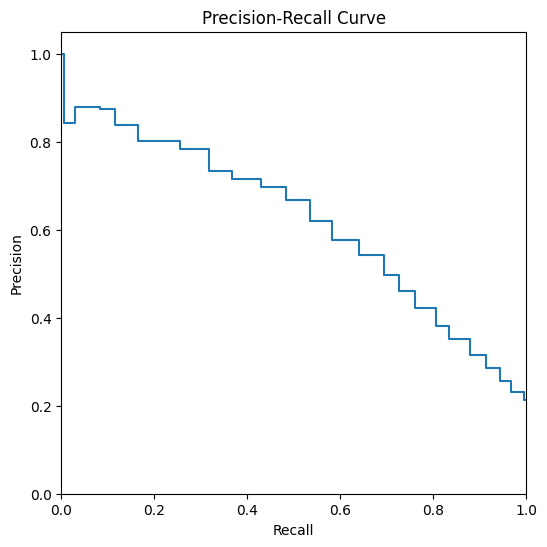

In [148]:
### Curva PR

precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

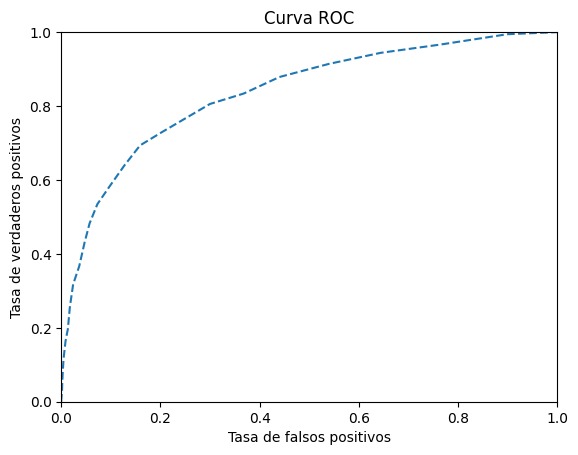

In [145]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < escribe el código aquí >

plt.figure()

plt.plot(fpr, tpr, linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])


plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')

plt.title('Curva ROC')

plt.show()